In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

import util

## 4.1.1 Normal by Addition

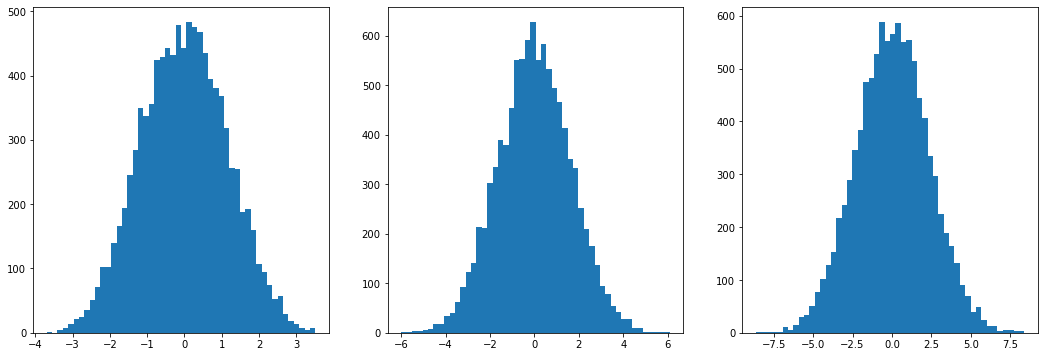

In [2]:
rng = np.random.RandomState(42)

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

for i, n_steps in enumerate([4, 8, 16]):
    pos = rng.uniform(-1, 1, size=(10000, n_steps))
    
    ax = axs[i]
    ax.hist(pos.sum(-1), bins=50)

# 4.3 Gaussian model of height

In [3]:
df = pl.read_csv("howell1.csv", sep=";")
print(util.summarize(df))

[pl.DataFrame of shape (544, 4):
┌────────┬───────┬───────────┬────────────┬───────────┬──────────┬───────────┬──────────────────┐
│ column ┆ dtype ┆ median    ┆ mean       ┆ std       ┆ 5.5%     ┆ 94.5%     ┆ histogram        │
│ ---    ┆ ---   ┆ ---       ┆ ---        ┆ ---       ┆ ---      ┆ ---       ┆ ---              │
│ str    ┆ str   ┆ f64       ┆ f64        ┆ f64       ┆ f64      ┆ f64       ┆ str              │
╞════════╪═══════╪═══════════╪════════════╪═══════════╪══════════╪═══════════╪══════════════════╡
│ height ┆ f64   ┆ 148.59    ┆ 138.263596 ┆ 27.602448 ┆ 81.10855 ┆ 165.735   ┆     ▁  ▁▁▁▁▄█▆▂  │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ weight ┆ f64   ┆ 40.057844 ┆ 35.610618  ┆ 14.719178 ┆ 9.360721 ┆ 54.502894 ┆ ▁▂▄▂▂▁▁▁▄▆█▇▅▃▁  │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ age    ┆ f64   ┆ 27.0      ┆ 29.344393  ┆ 20.746888 ┆ 1.0      ┆ 66.135    ┆ █▄▅▄▅▄

In [4]:
d2 = df.filter(pl.col('age') >= 18)
print(util.summarize(d2))

[pl.DataFrame of shape (352, 4):
┌────────┬───────┬──────────┬────────────┬───────────┬───────────┬───────────┬──────────────────┐
│ column ┆ dtype ┆ median   ┆ mean       ┆ std       ┆ 5.5%      ┆ 94.5%     ┆ histogram        │
│ ---    ┆ ---   ┆ ---      ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---              │
│ str    ┆ str   ┆ f64      ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆ str              │
╞════════╪═══════╪══════════╪════════════╪═══════════╪═══════════╪═══════════╪══════════════════╡
│ height ┆ f64   ┆ 154.305  ┆ 154.597093 ┆ 7.742332  ┆ 142.875   ┆ 167.005   ┆  ▁▃▄▆█▅▅▅▆▃▁▁    │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ weight ┆ f64   ┆ 44.79221 ┆ 44.990486  ┆ 6.456708  ┆ 35.137504 ┆ 55.765876 ┆ ▁▁▄▄▅▆▆▅█▄▃▂▃    │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ age    ┆ f64   ┆ 39.0     ┆ 41.138494  ┆ 15.967855 ┆ 20.0      ┆ 70.0      ┆ ▆▅▇▄▄█

## 4.3.5 Finding the posterior distribution with quap

In [5]:
import jax
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.optim as optim


def flist(height):
    mu = numpyro.sample("mu", dist.Normal(178, 20))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_1 = AutoLaplaceApproximation(flist)
svi = SVI(flist, m4_1, optim.Adam(1), Trace_ELBO(), height=d2["height"].to_numpy())
svi_result = svi.run(jax.random.PRNGKey(0), 2000)
p4_1 = svi_result.params

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 4378.86it/s, init loss: 4000.1155, avg. loss [1901-2000]: 1226.0389]


In [6]:
samples = m4_1.sample_posterior(jax.random.PRNGKey(1), p4_1, (10000,))
samples = pl.DataFrame({k: np.array(v) for k, v in samples.items()})
print(util.summarize(samples))

[pl.DataFrame of shape (10000, 2):
┌────────┬───────┬────────────┬────────────┬──────────┬────────────┬────────────┬──────────────────┐
│ column ┆ dtype ┆ median     ┆ mean       ┆ std      ┆ 5.5%       ┆ 94.5%      ┆ histogram        │
│ ---    ┆ ---   ┆ ---        ┆ ---        ┆ ---      ┆ ---        ┆ ---        ┆ ---              │
│ str    ┆ str   ┆ f32        ┆ f64        ┆ f32      ┆ f32        ┆ f32        ┆ str              │
╞════════╪═══════╪════════════╪════════════╪══════════╪════════════╪════════════╪══════════════════╡
│ mu     ┆ f32   ┆ 154.605164 ┆ 154.608674 ┆ 0.412593 ┆ 153.949341 ┆ 155.268768 ┆    ▁▂▅▇█▇▅▃▁     │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ sigma  ┆ f32   ┆ 7.739341   ┆ 7.745559   ┆ 0.291966 ┆ 7.286161   ┆ 8.225402   ┆    ▂▄▆█▇▆▃▁      │
└────────┴───────┴────────────┴────────────┴──────────┴────────────┴────────────┴──────────────────┘


# 4.4 Linear Prediction

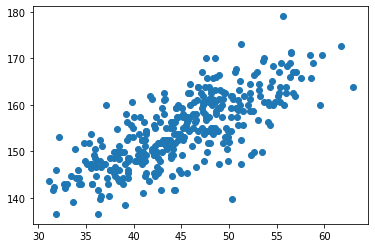

In [7]:
plt.scatter(d2['weight'], d2['height'])

In [8]:
mean_weight = d2["weight"].mean()

# Linear model for height given weight.
def model(weight, height):
    a = numpyro.sample("a", dist.Normal(178, 20))
    b = numpyro.sample("b", dist.LogNormal(0, 1))
    sigma = numpyro.sample("sigma", dist.Uniform(0, 50))
    mu = numpyro.deterministic("mu", a + b * (weight - mean_weight))
    numpyro.sample("height", dist.Normal(mu, sigma), obs=height)


m4_3 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m4_3,
    optim.Adam(1),
    Trace_ELBO(),
    weight=d2["weight"].to_numpy(),
    height=d2["height"].to_numpy(),
)
svi_result = svi.run(jax.random.PRNGKey(0), 2000)
p4_3 = svi_result.params

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 3300.43it/s, init loss: 40631.5391, avg. loss [1901-2000]: 1078.9297]


In [9]:
samples = m4_3.sample_posterior(jax.random.PRNGKey(1), p4_3, (1000,))
samples.pop("mu") # Without this line the kernel hangs?!
samples = pl.DataFrame({k: np.array(v) for k, v in samples.items()})
print(util.summarize(samples))

[pl.DataFrame of shape (1000, 3):
┌────────┬───────┬────────────┬──────────┬──────────┬────────────┬────────────┬──────────────────┐
│ column ┆ dtype ┆ median     ┆ mean     ┆ std      ┆ 5.5%       ┆ 94.5%      ┆ histogram        │
│ ---    ┆ ---   ┆ ---        ┆ ---      ┆ ---      ┆ ---        ┆ ---        ┆ ---              │
│ str    ┆ str   ┆ f32        ┆ f64      ┆ f32      ┆ f32        ┆ f32        ┆ str              │
╞════════╪═══════╪════════════╪══════════╪══════════╪════════════╪════════════╪══════════════════╡
│ a      ┆ f32   ┆ 154.628464 ┆ 154.6194 ┆ 0.274087 ┆ 154.173386 ┆ 155.043137 ┆    ▁▂▃▄▇█▇▅▄▂▁   │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ b      ┆ f32   ┆ 0.904235   ┆ 0.905715 ┆ 0.042672 ┆ 0.84       ┆ 0.9764     ┆    ▁▂▅▇█▆▄▂▁     │
├╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ sigma  ┆ f32   ┆ 5.0831     ┆ 5.084587 ┆ 0.194483 ┆ 4.790803   ┆ 5.410045

In [10]:
util.covariance(samples)

name,a,b,sigma
str,f64,f64,f64
"""a""",0.075123,-0.0001,0.001269
"""b""",-0.0001,0.001821,-0.000076
"""sigma""",0.001269,-0.000076,0.037823


Text(0, 0.5, 'height')

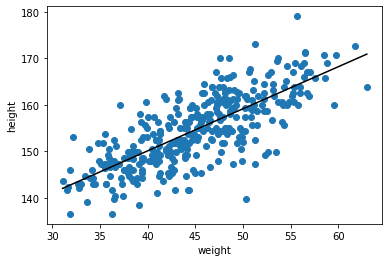

In [17]:
# Scatter plot of original data and line showing model parameter mean.
fig, ax = plt.subplots()
ax.scatter(d2['weight'], d2['height']) 
x = np.linspace(d2['weight'].min(), d2['weight'].max(), 101)
ax.plot(x, samples['a'].mean() + samples['b'].mean() * (x - mean_weight), "k")

ax.set_xlabel('weight')
ax.set_ylabel('height')

In [25]:
weights = np.arange(start=d2["weight"].min(), stop=d2["weight"].max(), step=1)

# Compute mu for each sample from posterior and for each weight in weight_seq.
post = m4_3.sample_posterior(jax.random.PRNGKey(1), p4_3, (1000,))
mu_pred = Predictive(m4_3.model, post, return_sites=["mu"])
mu = mu_pred(jax.random.PRNGKey(2), weights, None)["mu"]
print(mu.shape)

(1000, 32)


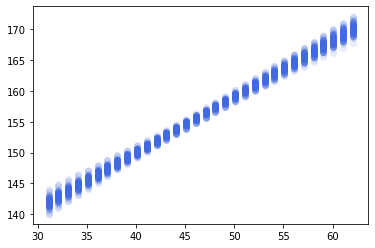

In [33]:
# Plot distribution of sampled mu values.
for i in range(100):
    plt.plot(weights, mu[i], "o", c="royalblue", alpha=0.1)

Text(0, 0.5, 'height')

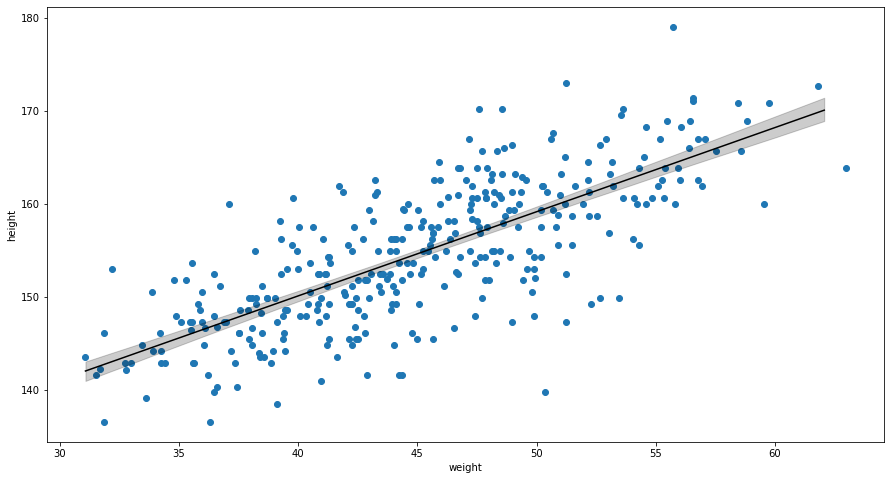

In [44]:
# Scatter plot of original data, line showing model parameter mean
# and shaded region showing confidence interval for the mean.

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(d2['weight'], d2['height']) 
ax.plot(weights, mu.mean(axis=0), "k")

# Shaded region for confidence interval of mu.
mu_PI = np.percentile(mu, q=[5.5, 94.5], axis=0)
plt.fill_between(weights, mu_PI[0], mu_PI[1], color="k", alpha=0.2) 

ax.set_xlabel('weight')
ax.set_ylabel('height')

In [47]:
# Compute mu for each sample from posterior and for each weight in weight_seq.
post = m4_3.sample_posterior(jax.random.PRNGKey(1), p4_3, (10000,))
height_pred = Predictive(m4_3.model, post, return_sites=["height"])
height_samples = height_pred(jax.random.PRNGKey(2), weights, None)["height"]
print(height_samples.shape)

(10000, 32)


Text(0, 0.5, 'height')

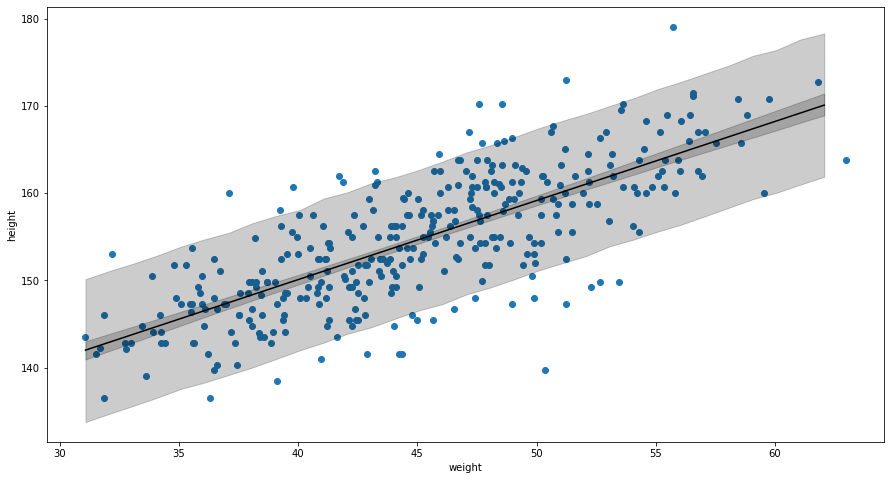

In [48]:
# Scatter plot of original data, line showing model parameter mean
# and shaded regions showing confidence interval for the mean and heights.

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(d2['weight'], d2['height']) 
ax.plot(weights, mu.mean(axis=0), "k")

# Shaded region for confidence interval of mu.
mu_PI = np.percentile(mu, q=[5.5, 94.5], axis=0)
plt.fill_between(weights, mu_PI[0], mu_PI[1], color="k", alpha=0.2) 

# Shaded region for confidence interval of heights.
height_PI = np.percentile(height_samples, q=[5.5, 94.5], axis=0)
plt.fill_between(weights, height_PI[0], height_PI[1], color="k", alpha=0.2) 

ax.set_xlabel('weight')
ax.set_ylabel('height')